<a href="https://colab.research.google.com/github/MaladAhmed/Diabetic-Retinopathy-Classifier-Using-ResNet512/blob/main/Fine_Tuned_ResNet18_DR_Classifier_(98_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, datasets, models
import copy
import time
import shutil
import seaborn as sns
import cv2
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from PIL import Image
from torch.utils.data import Dataset
from zipfile import ZipFile
import pathlib
from sklearn.model_selection import train_test_split
from glob import glob


In [ ]:
!cd ../root/

Use your kaggle API to download the dataset

In [ ]:
!echo '{"username":"ahmedbenlahrech","key":"xx"}' > /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

 98% 418M/427M [00:04<00:00, 118MB/s]
100% 427M/427M [00:04<00:00, 105MB/s]


In [ ]:

with ZipFile("/content/diabetic-retinopathy-224x224-gaussian-filtered.zip", 'r') as zObject:
    zObject.extractall(
        path="/content/diabetic-retinopathy-224x224-gaussian-filtered")


In [ ]:

df = pd.read_csv(r'/content/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

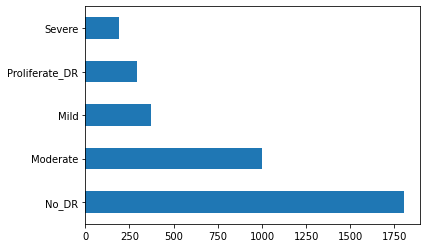

In [ ]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

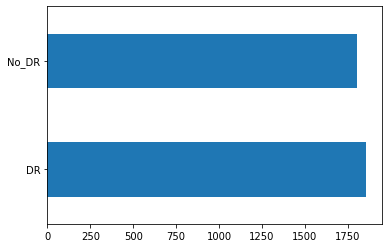

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

Preparing the Dataset and the DataLoader :

---



In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

train


In [ ]:
train.head()

,id_code,diagnosis,binary_type,type
2059,90960ddf4d14,0,No_DR,No_DR
1287,599b89048034,2,DR,Moderate
1248,5728b8aa98ef,0,No_DR,No_DR
2196,9a4f370d341b,2,DR,Moderate
1885,84b88e8d3bca,0,No_DR,No_DR


In [ ]:
# Copy images to respective working directory
src_dir = '/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [ ]:
train.head()

,id_code,diagnosis,binary_type,type
2059,90960ddf4d14,0,No_DR,No_DR
1287,599b89048034,2,DR,Moderate
1248,5728b8aa98ef,0,No_DR,No_DR
2196,9a4f370d341b,2,DR,Moderate
1885,84b88e8d3bca,0,No_DR,No_DR


In [ ]:
train_binarylabled = train


In [ ]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import os



class MyDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:

data_transform= {
    'train' : transforms.Compose([
        transforms.ToTensor()
        ,transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [ ]:
data_rootdir = '/content/'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_rootdir,x),data_transform[x]) for x in ['train','val'] }

In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 2562
     Root location: /content/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 550
     Root location: /content/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
# Initializing some Hyperparameters:

BATCH_SIZE = 32
NUM_WORKERS = 4

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train','val'] }
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
print(dataloaders)
print(dataset_sizes)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f86c81c0730>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f86c81c0640>}
{'train': 2562, 'val': 550}


In [ ]:
class_names = image_datasets['train'].classes
class_names

['DR', 'No_DR']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Visualize some images 

In [ ]:
def imageshow(inp, title=None):
  inp = inp.numpy().transpose([1,2,0])
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = inp*std + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [ ]:
imageinputs, imageclasses = next(iter(dataloaders['train']))
imageinputs.shape, imageclasses

(torch.Size([32, 3, 224, 224]),
 tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 0]))

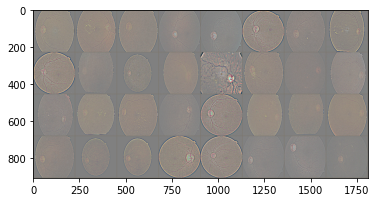

In [ ]:
visualization_output = torchvision.utils.make_grid(imageinputs)
imageshow(visualization_output)

Training the model :
*   Scheduling the learning rate
*   Saving the best model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing some samples throughout the training phase

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imageshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Importing ResNet for Transfer learning and finetuning

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 0/34
----------
train Loss: 0.2635 Acc: 0.8934


  3%|▎         | 1/35 [00:20<11:33, 20.40s/it]

val Loss: 0.1229 Acc: 0.9655

Epoch 1/34
----------
train Loss: 0.1403 Acc: 0.9539


  6%|▌         | 2/35 [00:31<08:19, 15.14s/it]

val Loss: 0.1063 Acc: 0.9727

Epoch 2/34
----------
train Loss: 0.0909 Acc: 0.9699


  9%|▊         | 3/35 [00:43<07:06, 13.32s/it]

val Loss: 0.0744 Acc: 0.9727

Epoch 3/34
----------
train Loss: 0.0800 Acc: 0.9707


 11%|█▏        | 4/35 [00:54<06:34, 12.72s/it]

val Loss: 0.0648 Acc: 0.9745

Epoch 4/34
----------
train Loss: 0.0582 Acc: 0.9809


 14%|█▍        | 5/35 [01:06<06:11, 12.38s/it]

val Loss: 0.0720 Acc: 0.9727

Epoch 5/34
----------
train Loss: 0.0276 Acc: 0.9930


 17%|█▋        | 6/35 [01:18<05:53, 12.19s/it]

val Loss: 0.0674 Acc: 0.9800

Epoch 6/34
----------
train Loss: 0.0226 Acc: 0.9934


 20%|██        | 7/35 [01:30<05:38, 12.08s/it]

val Loss: 0.0590 Acc: 0.9818

Epoch 7/34
----------
train Loss: 0.0137 Acc: 0.9988


 23%|██▎       | 8/35 [01:43<05:32, 12.30s/it]

val Loss: 0.0594 Acc: 0.9800

Epoch 8/34
----------
train Loss: 0.0156 Acc: 0.9961


 26%|██▌       | 9/35 [01:54<05:16, 12.16s/it]

val Loss: 0.0621 Acc: 0.9782

Epoch 9/34
----------
train Loss: 0.0148 Acc: 0.9977


 29%|██▊       | 10/35 [02:06<04:59, 11.97s/it]

val Loss: 0.0640 Acc: 0.9800

Epoch 10/34
----------
train Loss: 0.0138 Acc: 0.9969


 31%|███▏      | 11/35 [02:17<04:43, 11.83s/it]

val Loss: 0.0612 Acc: 0.9800

Epoch 11/34
----------
train Loss: 0.0138 Acc: 0.9957


 34%|███▍      | 12/35 [02:29<04:33, 11.88s/it]

val Loss: 0.0608 Acc: 0.9800

Epoch 12/34
----------
train Loss: 0.0129 Acc: 0.9980


 37%|███▋      | 13/35 [02:41<04:19, 11.78s/it]

val Loss: 0.0594 Acc: 0.9800

Epoch 13/34
----------
train Loss: 0.0140 Acc: 0.9973


 40%|████      | 14/35 [02:53<04:06, 11.72s/it]

val Loss: 0.0588 Acc: 0.9800

Epoch 14/34
----------
train Loss: 0.0102 Acc: 0.9992


 43%|████▎     | 15/35 [03:04<03:54, 11.74s/it]

val Loss: 0.0637 Acc: 0.9818

Epoch 15/34
----------
train Loss: 0.0118 Acc: 0.9984


 46%|████▌     | 16/35 [03:16<03:44, 11.81s/it]

val Loss: 0.0599 Acc: 0.9818

Epoch 16/34
----------
train Loss: 0.0130 Acc: 0.9973


 49%|████▊     | 17/35 [03:28<03:32, 11.82s/it]

val Loss: 0.0606 Acc: 0.9800

Epoch 17/34
----------
train Loss: 0.0113 Acc: 0.9977


 51%|█████▏    | 18/35 [03:40<03:22, 11.88s/it]

val Loss: 0.0606 Acc: 0.9800

Epoch 18/34
----------
train Loss: 0.0107 Acc: 0.9980


 54%|█████▍    | 19/35 [03:52<03:09, 11.86s/it]

val Loss: 0.0616 Acc: 0.9782

Epoch 19/34
----------
train Loss: 0.0128 Acc: 0.9973


 57%|█████▋    | 20/35 [04:04<02:58, 11.92s/it]

val Loss: 0.0708 Acc: 0.9764

Epoch 20/34
----------
train Loss: 0.0120 Acc: 0.9988


 60%|██████    | 21/35 [04:16<02:46, 11.91s/it]

val Loss: 0.0605 Acc: 0.9800

Epoch 21/34
----------
train Loss: 0.0114 Acc: 0.9984


 63%|██████▎   | 22/35 [04:28<02:34, 11.85s/it]

val Loss: 0.0594 Acc: 0.9800

Epoch 22/34
----------
train Loss: 0.0123 Acc: 0.9980


 66%|██████▌   | 23/35 [04:40<02:22, 11.87s/it]

val Loss: 0.0636 Acc: 0.9818

Epoch 23/34
----------
train Loss: 0.0126 Acc: 0.9980


 69%|██████▊   | 24/35 [04:52<02:11, 11.92s/it]

val Loss: 0.0678 Acc: 0.9782

Epoch 24/34
----------
train Loss: 0.0137 Acc: 0.9977


 71%|███████▏  | 25/35 [05:03<01:58, 11.86s/it]

val Loss: 0.0591 Acc: 0.9818

Epoch 25/34
----------
train Loss: 0.0124 Acc: 0.9980


 74%|███████▍  | 26/35 [05:15<01:46, 11.83s/it]

val Loss: 0.0636 Acc: 0.9764

Epoch 26/34
----------
train Loss: 0.0142 Acc: 0.9965


 77%|███████▋  | 27/35 [05:27<01:34, 11.85s/it]

val Loss: 0.0665 Acc: 0.9745

Epoch 27/34
----------
train Loss: 0.0147 Acc: 0.9965


 80%|████████  | 28/35 [05:39<01:23, 11.95s/it]

val Loss: 0.0595 Acc: 0.9782

Epoch 28/34
----------
train Loss: 0.0110 Acc: 0.9977


 83%|████████▎ | 29/35 [05:51<01:11, 11.99s/it]

val Loss: 0.0666 Acc: 0.9782

Epoch 29/34
----------
train Loss: 0.0098 Acc: 0.9988


 86%|████████▌ | 30/35 [06:03<00:59, 11.97s/it]

val Loss: 0.0590 Acc: 0.9800

Epoch 30/34
----------
train Loss: 0.0120 Acc: 0.9969


 89%|████████▊ | 31/35 [06:15<00:47, 11.93s/it]

val Loss: 0.0603 Acc: 0.9782

Epoch 31/34
----------
train Loss: 0.0113 Acc: 0.9980


 91%|█████████▏| 32/35 [06:27<00:35, 11.94s/it]

val Loss: 0.0627 Acc: 0.9800

Epoch 32/34
----------
train Loss: 0.0124 Acc: 0.9973


 94%|█████████▍| 33/35 [06:39<00:23, 11.96s/it]

val Loss: 0.0616 Acc: 0.9800

Epoch 33/34
----------
train Loss: 0.0110 Acc: 0.9980


 97%|█████████▋| 34/35 [06:51<00:11, 11.92s/it]

val Loss: 0.0614 Acc: 0.9818

Epoch 34/34
----------
train Loss: 0.0129 Acc: 0.9977


100%|██████████| 35/35 [07:03<00:00, 12.09s/it]

val Loss: 0.0603 Acc: 0.9800

Training complete in 7m 3s
Best val Acc: 0.981818
